In [1]:
import sys
sys.path.insert(0, '../../pyLDLE2/')

import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.linalg import pinv

import ConnectionNetworkX_v2 as cnx

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from pyLDLE2 import datasets, visualize_

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX_v2' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/ConnectionNetworkX_v2.py'>

In [3]:
def draw3d(G, pos, node_color, node_size, edge_color, figsize=(8,4)):# 3d spring layout
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        ax.plot(*vizedge.T, color=edge_color[i])

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load torus data

In [53]:
X, labelsMat, _ = datasets.Datasets().curvedtorus3d(n=3000)

X.shape =  (3000, 3)


<IPython.core.display.Javascript object>


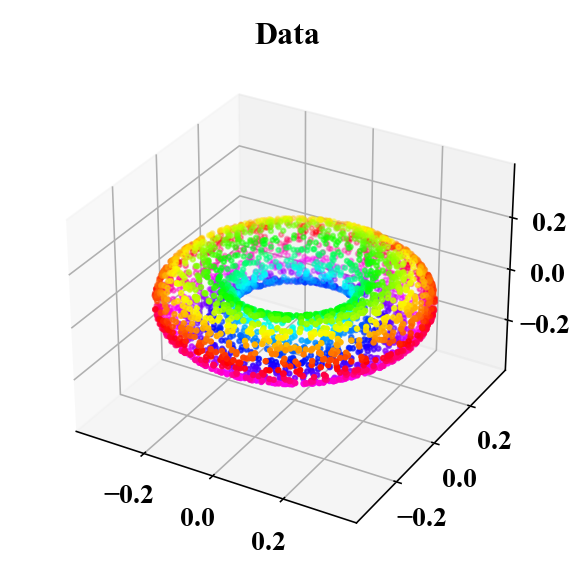

In [54]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X, labelsMat[:,0], cmap='hsv', figsize=(4,4))

In [6]:
from scipy.spatial.distance import pdist, squareform
d_e = squareform(pdist(X))

In [7]:
np.sort(d_e[50,:])[:100]

array([0.        , 0.01227912, 0.02061771, 0.02453866, 0.0249528 ,
       0.02579382, 0.02702347, 0.02783541, 0.02963681, 0.03503061,
       0.03547225, 0.03596439, 0.03597056, 0.03778997, 0.0378804 ,
       0.03809281, 0.03818268, 0.04215674, 0.0423356 , 0.04266648,
       0.04304861, 0.04408368, 0.04511536, 0.04598464, 0.04767364,
       0.04861725, 0.05028097, 0.05092954, 0.05168977, 0.05243288,
       0.05253296, 0.05369488, 0.05386583, 0.05546136, 0.05552083,
       0.05843902, 0.05850102, 0.0588718 , 0.0606537 , 0.06072057,
       0.06319354, 0.06368548, 0.06779433, 0.06833557, 0.06961369,
       0.07049643, 0.07054174, 0.07066345, 0.07068695, 0.07107848,
       0.07180483, 0.07222207, 0.07222393, 0.07305345, 0.07337381,
       0.07341411, 0.07379189, 0.07500752, 0.07539597, 0.07565647,
       0.07579468, 0.07596671, 0.07623506, 0.07745844, 0.07826596,
       0.07845518, 0.08024058, 0.0814565 , 0.08204656, 0.08314442,
       0.08558493, 0.08636741, 0.08681108, 0.08691474, 0.08743

In [8]:
np.argsort(d_e[50,:])[:1000]

array([  50,  648,  787, 2384, 1571, 1700,  718,  918,  916, 1270, 1829,
        552, 1349, 2308, 1502,  834, 1861, 2610, 2922, 1058, 2519,  783,
       1589, 2389, 2699, 2321, 1874, 1614, 1216, 2651,  761, 1026,  939,
        633, 2688, 2404,  577,  569, 1504,  543,  401, 1019, 2068,  107,
       2667,  277,  147, 2761,  439, 1763,  990,  150, 2299, 2593, 1979,
       1124, 2692, 2186,  722, 1900, 1366,  893, 1318, 2410, 2554, 2102,
       2728,  430, 1469, 2758,  375, 2169,  451, 1105, 1034,  568, 1482,
       2363, 1846, 2392,  410, 1145, 1569, 1489,  879, 1544, 1177, 2148,
       1982, 2876, 2297,  537, 1687, 2965, 1468, 1211,  357, 1707, 2314,
        380, 2706,  156, 2234, 2733,  956,  811,  915, 2606,  539, 1629,
       1261, 1889,  997, 1103, 2130, 2511,  249, 2911, 1850,  201,  947,
       1392, 1133,   95,  403,  545, 1671,  173,  719, 2813, 1161, 2649,
       2402,  548, 1134, 1872, 1747, 1111, 2952, 2033, 1379, 1443, 1987,
       1162,  760, 2960,  897, 2337, 2222,   98, 10

In [9]:
d_e[50,np.argsort(d_e[50,:])][:100]

array([0.        , 0.01227912, 0.02061771, 0.02453866, 0.0249528 ,
       0.02579382, 0.02702347, 0.02783541, 0.02963681, 0.03503061,
       0.03547225, 0.03596439, 0.03597056, 0.03778997, 0.0378804 ,
       0.03809281, 0.03818268, 0.04215674, 0.0423356 , 0.04266648,
       0.04304861, 0.04408368, 0.04511536, 0.04598464, 0.04767364,
       0.04861725, 0.05028097, 0.05092954, 0.05168977, 0.05243288,
       0.05253296, 0.05369488, 0.05386583, 0.05546136, 0.05552083,
       0.05843902, 0.05850102, 0.0588718 , 0.0606537 , 0.06072057,
       0.06319354, 0.06368548, 0.06779433, 0.06833557, 0.06961369,
       0.07049643, 0.07054174, 0.07066345, 0.07068695, 0.07107848,
       0.07180483, 0.07222207, 0.07222393, 0.07305345, 0.07337381,
       0.07341411, 0.07379189, 0.07500752, 0.07539597, 0.07565647,
       0.07579468, 0.07596671, 0.07623506, 0.07745844, 0.07826596,
       0.07845518, 0.08024058, 0.0814565 , 0.08204656, 0.08314442,
       0.08558493, 0.08636741, 0.08681108, 0.08691474, 0.08743

<IPython.core.display.Javascript object>


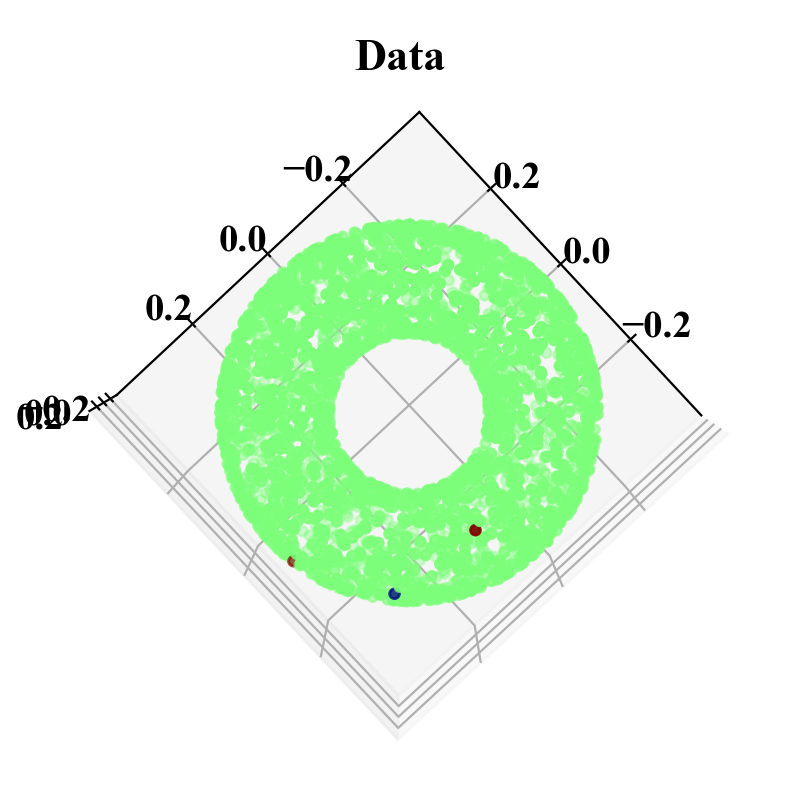

In [10]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[50] = -1
labels[1332] = 1
labels[1929] = 1
vis.data(X, labels, cmap='jet', figsize=(4,4), s=50, elev=93, azim=137)

#  build connection graph

In [49]:
#NEAREST_NEIGHBORS = 13
INTRINSIC_DIMENSION = 2

#CG = cnx.cnxFromData(X, k=NEAREST_NEIGHBORS, d=INTRINSIC_DIMENSION)
CG = cnx.cnxFromData_v2(X, 0.03, 0.06, d=INTRINSIC_DIMENSION, tol=0.5)

Total edges before removal: 51207


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 876.45it/s]


Proportion of edges which were removed due to remoteness:  0.09526041361532603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [17:40<00:00,  2.83it/s]


In [50]:
nx.is_connected(CG)

False

# Set B, w, mu, nu, c

In [55]:
d = INTRINSIC_DIMENSION
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
W = np.ones(B.shape[0]//d).astype('float32')

np.random.seed(42)
#source = np.random.randint(0, CG.number_of_nodes())
#dest = np.random.randint(0, CG.number_of_nodes())
source = 50 #0 #0
dest1 = 1332 #543 #364 #465
dest2 = 1929 #439 #332 #221

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest1 * d, :] = 1
nu[dest2 * d+1, :] = 1

c = (mu - nu)

In [56]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

/tmp/ipykernel_17240/426106341.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)


1.6222957511354274e-14

In [57]:
def optimize_(B, W, c, learning_rate=0.1, alpha=1, n_epochs=10000, phi0=None):
    B_torch = torch.tensor(B.toarray().astype('float32'))
    w_torch = torch.tensor(W.astype('float32'))
    c_torch = torch.tensor(c.astype('float32'))
    
    if phi0 == 'least_squares':
        phi0 = pinv(B.T.dot(B).toarray()).dot(c).astype('float32')
    
    if phi0 is not None:
        print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B_torch, w_torch, c_torch))
    
    phi = cnx.optimize(B_torch, w_torch, c_torch, alpha, learning_rate, n_epochs, phi0 = phi0)
    return phi.detach().numpy(), phi0

In [58]:
learning_rate = 0.5
alpha = 2000
n_epochs = 10000

phi, phi0 = optimize_(B, W, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

# phi0 = phi

# phi0 = np.ones(B.shape[1], dtype='float32')
# #s_d_path = nx.all_shortest_paths(CG, source ,dest)
# #s_d_path = nx.shortest_path(CG, source ,dest, weight='weight')
# s_d_path = np.unique(list(nx.all_shortest_paths(CG, source ,dest)))
# for i in range(len(s_d_path)):
#     phi0[s_d_path[i]*d:(s_d_path[i]+1)*d] = 10

# phi0 = phi0*np.random.uniform(0, 10, phi0.shape).astype('float32')
# #phi0 = phi0.astype('float32')
# #phi0 = None



Initial loss: (tensor(-0.9237), tensor(0.))
epoch: 0, loss: -0.923688, loss0: -0.923688, loss1: 0.000000
epoch: 10, loss: -20.899492, loss0: -20.921869, loss1: 89.507584
epoch: 20, loss: -40.674725, loss0: -40.891823, loss1: 868.392639
epoch: 30, loss: -60.167416, loss0: -60.794964, loss1: 2510.191650
epoch: 40, loss: -79.355263, loss0: -80.607979, loss1: 5010.860840
epoch: 50, loss: -98.228096, loss0: -100.318008, loss1: 8359.650391
epoch: 60, loss: -116.782333, loss0: -119.918411, loss1: 12544.312500
epoch: 70, loss: -135.018280, loss0: -139.405945, loss1: 17550.660156
epoch: 80, loss: -152.937912, loss0: -158.778976, loss1: 23364.232422
epoch: 90, loss: -170.544052, loss0: -178.036774, loss1: 29970.863281
epoch: 100, loss: -187.840057, loss0: -197.178787, loss1: 37354.917969
epoch: 110, loss: -204.828903, loss0: -216.204742, loss1: 45503.359375
epoch: 120, loss: -221.514725, loss0: -235.114349, loss1: 54398.507812
epoch: 130, loss: -237.900665, loss0: -253.907379, loss1: 64026.82031

epoch: 1130, loss: -901.302917, loss0: -1519.386597, loss1: 2472334.500000
epoch: 1140, loss: -902.616455, loss0: -1526.087158, loss1: 2493882.750000
epoch: 1150, loss: -903.889343, loss0: -1532.685303, loss1: 2515183.750000
epoch: 1160, loss: -905.122253, loss0: -1539.182373, loss1: 2536240.250000
epoch: 1170, loss: -906.316345, loss0: -1545.578979, loss1: 2557050.500000
epoch: 1180, loss: -907.472717, loss0: -1551.875977, loss1: 2577613.000000
epoch: 1190, loss: -908.592468, loss0: -1558.074219, loss1: 2597927.000000
epoch: 1200, loss: -909.676880, loss0: -1564.174805, loss1: 2617991.500000
epoch: 1210, loss: -910.727112, loss0: -1570.178101, loss1: 2637803.750000
epoch: 1220, loss: -911.743469, loss0: -1576.085327, loss1: 2657367.250000
epoch: 1230, loss: -912.727600, loss0: -1581.897583, loss1: 2676679.750000
epoch: 1240, loss: -913.680115, loss0: -1587.615479, loss1: 2695741.250000
epoch: 1250, loss: -914.601685, loss0: -1593.239990, loss1: 2714553.000000
epoch: 1260, loss: -915.4

epoch: 2230, loss: -939.606445, loss0: -1839.828125, loss1: 3600886.500000
epoch: 2240, loss: -939.625610, loss0: -1840.523315, loss1: 3603590.750000
epoch: 2250, loss: -939.643677, loss0: -1841.201172, loss1: 3606229.750000
epoch: 2260, loss: -939.661255, loss0: -1841.861938, loss1: 3608802.500000
epoch: 2270, loss: -939.678162, loss0: -1842.506104, loss1: 3611311.500000
epoch: 2280, loss: -939.693909, loss0: -1843.133789, loss1: 3613759.250000
epoch: 2290, loss: -939.709045, loss0: -1843.745605, loss1: 3616146.000000
epoch: 2300, loss: -939.722900, loss0: -1844.341675, loss1: 3618475.000000
epoch: 2310, loss: -939.736938, loss0: -1844.922241, loss1: 3620741.000000
epoch: 2320, loss: -939.749878, loss0: -1845.487915, loss1: 3622952.000000
epoch: 2330, loss: -939.762207, loss0: -1846.039062, loss1: 3625107.250000
epoch: 2340, loss: -939.773926, loss0: -1846.575928, loss1: 3627207.750000
epoch: 2350, loss: -939.784973, loss0: -1847.098633, loss1: 3629254.500000
epoch: 2360, loss: -939.7

epoch: 3330, loss: -939.973572, loss0: -1863.558716, loss1: 3694340.500000
epoch: 3340, loss: -939.973389, loss0: -1863.576904, loss1: 3694414.000000
epoch: 3350, loss: -939.973267, loss0: -1863.594238, loss1: 3694483.750000
epoch: 3360, loss: -939.973450, loss0: -1863.610840, loss1: 3694549.500000
epoch: 3370, loss: -939.973816, loss0: -1863.626709, loss1: 3694611.500000
epoch: 3380, loss: -939.973816, loss0: -1863.641846, loss1: 3694672.000000
epoch: 3390, loss: -939.973755, loss0: -1863.656250, loss1: 3694729.750000
epoch: 3400, loss: -939.973572, loss0: -1863.670044, loss1: 3694785.750000
epoch: 3410, loss: -939.973511, loss0: -1863.683350, loss1: 3694839.250000
epoch: 3420, loss: -939.973450, loss0: -1863.696045, loss1: 3694890.250000
epoch: 3430, loss: -939.973511, loss0: -1863.708008, loss1: 3694937.750000
epoch: 3440, loss: -939.973755, loss0: -1863.719482, loss1: 3694982.750000
epoch: 3450, loss: -939.973633, loss0: -1863.730225, loss1: 3695026.250000
epoch: 3460, loss: -939.9

epoch: 4430, loss: -939.973816, loss0: -1863.932373, loss1: 3695834.000000
epoch: 4440, loss: -939.973877, loss0: -1863.932373, loss1: 3695833.750000
epoch: 4450, loss: -939.973816, loss0: -1863.932373, loss1: 3695834.000000
epoch: 4460, loss: -939.973694, loss0: -1863.932373, loss1: 3695834.500000
epoch: 4470, loss: -939.973450, loss0: -1863.932373, loss1: 3695835.500000
epoch: 4480, loss: -939.973083, loss0: -1863.932373, loss1: 3695837.000000
epoch: 4490, loss: -939.973694, loss0: -1863.932495, loss1: 3695835.000000
epoch: 4500, loss: -939.973816, loss0: -1863.932495, loss1: 3695834.500000
epoch: 4510, loss: -939.973938, loss0: -1863.932495, loss1: 3695834.000000
epoch: 4520, loss: -939.973816, loss0: -1863.932495, loss1: 3695834.500000
epoch: 4530, loss: -939.973755, loss0: -1863.932495, loss1: 3695834.750000
epoch: 4540, loss: -939.973572, loss0: -1863.932495, loss1: 3695835.500000
epoch: 4550, loss: -939.973816, loss0: -1863.932495, loss1: 3695834.500000
epoch: 4560, loss: -939.9

epoch: 5530, loss: -939.973450, loss0: -1863.933960, loss1: 3695841.750000
epoch: 5540, loss: -939.973572, loss0: -1863.933838, loss1: 3695841.000000
epoch: 5550, loss: -939.973816, loss0: -1863.934082, loss1: 3695841.000000
epoch: 5560, loss: -939.973633, loss0: -1863.934082, loss1: 3695841.500000
epoch: 5570, loss: -939.973511, loss0: -1863.934082, loss1: 3695842.000000
epoch: 5580, loss: -939.973267, loss0: -1863.934082, loss1: 3695843.000000
epoch: 5590, loss: -939.973633, loss0: -1863.934082, loss1: 3695841.500000
epoch: 5600, loss: -939.973633, loss0: -1863.934082, loss1: 3695841.500000
epoch: 5610, loss: -939.973755, loss0: -1863.934082, loss1: 3695841.250000
epoch: 5620, loss: -939.973511, loss0: -1863.934082, loss1: 3695842.000000
epoch: 5630, loss: -939.973267, loss0: -1863.934326, loss1: 3695844.000000
epoch: 5640, loss: -939.973633, loss0: -1863.934326, loss1: 3695842.500000
epoch: 5650, loss: -939.973694, loss0: -1863.934326, loss1: 3695842.250000
epoch: 5660, loss: -939.9

epoch: 6630, loss: -939.973877, loss0: -1863.934692, loss1: 3695843.000000
epoch: 6640, loss: -939.973816, loss0: -1863.934692, loss1: 3695843.250000
epoch: 6650, loss: -939.973877, loss0: -1863.934692, loss1: 3695843.000000
epoch: 6660, loss: -939.973816, loss0: -1863.934692, loss1: 3695843.250000
epoch: 6670, loss: -939.973694, loss0: -1863.934692, loss1: 3695843.750000
epoch: 6680, loss: -939.973267, loss0: -1863.934692, loss1: 3695845.500000
epoch: 6690, loss: -939.973633, loss0: -1863.934570, loss1: 3695843.500000
epoch: 6700, loss: -939.973633, loss0: -1863.934692, loss1: 3695844.000000
epoch: 6710, loss: -939.973755, loss0: -1863.934692, loss1: 3695843.500000
epoch: 6720, loss: -939.973816, loss0: -1863.934692, loss1: 3695843.250000
epoch: 6730, loss: -939.973755, loss0: -1863.934692, loss1: 3695843.500000
epoch: 6740, loss: -939.973511, loss0: -1863.934692, loss1: 3695844.500000
epoch: 6750, loss: -939.973267, loss0: -1863.934814, loss1: 3695846.000000
epoch: 6760, loss: -939.9

epoch: 7730, loss: -939.973755, loss0: -1863.935303, loss1: 3695846.000000
epoch: 7740, loss: -939.973694, loss0: -1863.935303, loss1: 3695846.250000
epoch: 7750, loss: -939.973572, loss0: -1863.935303, loss1: 3695846.750000
epoch: 7760, loss: -939.973145, loss0: -1863.935547, loss1: 3695849.500000
epoch: 7770, loss: -939.973633, loss0: -1863.935425, loss1: 3695847.000000
epoch: 7780, loss: -939.973633, loss0: -1863.935425, loss1: 3695847.000000
epoch: 7790, loss: -939.973755, loss0: -1863.935425, loss1: 3695846.500000
epoch: 7800, loss: -939.973755, loss0: -1863.935303, loss1: 3695846.000000
epoch: 7810, loss: -939.973633, loss0: -1863.935303, loss1: 3695846.500000
epoch: 7820, loss: -939.973511, loss0: -1863.935303, loss1: 3695847.000000
epoch: 7830, loss: -939.973511, loss0: -1863.935425, loss1: 3695847.500000
epoch: 7840, loss: -939.973633, loss0: -1863.935425, loss1: 3695847.000000
epoch: 7850, loss: -939.973755, loss0: -1863.935425, loss1: 3695846.500000
epoch: 7860, loss: -939.9

epoch: 8830, loss: -939.973633, loss0: -1863.935303, loss1: 3695846.500000
epoch: 8840, loss: -939.973755, loss0: -1863.935425, loss1: 3695846.500000
epoch: 8850, loss: -939.973511, loss0: -1863.935425, loss1: 3695847.500000
epoch: 8860, loss: -939.973389, loss0: -1863.935425, loss1: 3695848.000000
epoch: 8870, loss: -939.973633, loss0: -1863.935303, loss1: 3695846.500000
epoch: 8880, loss: -939.973755, loss0: -1863.935303, loss1: 3695846.000000
epoch: 8890, loss: -939.973633, loss0: -1863.935303, loss1: 3695846.500000
epoch: 8900, loss: -939.973389, loss0: -1863.935425, loss1: 3695848.000000
epoch: 8910, loss: -939.973511, loss0: -1863.935303, loss1: 3695847.000000
epoch: 8920, loss: -939.973694, loss0: -1863.935303, loss1: 3695846.250000
epoch: 8930, loss: -939.973755, loss0: -1863.935547, loss1: 3695847.000000
epoch: 8940, loss: -939.973633, loss0: -1863.935303, loss1: 3695846.500000
epoch: 8950, loss: -939.973633, loss0: -1863.935547, loss1: 3695847.500000
epoch: 8960, loss: -939.9

epoch: 9930, loss: -939.973755, loss0: -1863.935547, loss1: 3695847.000000
epoch: 9940, loss: -939.973694, loss0: -1863.935425, loss1: 3695846.750000
epoch: 9950, loss: -939.973755, loss0: -1863.935669, loss1: 3695847.500000
epoch: 9960, loss: -939.973511, loss0: -1863.935425, loss1: 3695847.500000
epoch: 9970, loss: -939.973633, loss0: -1863.935547, loss1: 3695847.500000
epoch: 9980, loss: -939.973816, loss0: -1863.935303, loss1: 3695845.750000
epoch: 9990, loss: -939.973633, loss0: -1863.935303, loss1: 3695846.500000


In [60]:
def edge_score_(phi, B, W, c):
    B_torch = torch.tensor(B.toarray().astype('float32'))
    w_torch = torch.tensor(W.astype('float32'))
    c_torch = torch.tensor(c.astype('float32'))
    edge_score = cnx.active_edges(torch.tensor(phi), B_torch, w_torch, c_torch)
    return edge_score.detach().numpy()

In [61]:
def optimal_J_(phi, B, W, c, d):
    B_torch = torch.tensor(B.toarray().astype('float32'))
    w_torch = torch.tensor(W.astype('float32'))
    c_torch = torch.tensor(c.astype('float32'))
    J_opt = cnx.optimal_J(torch.tensor(phi), B_torch, w_torch, alpha, d)
    J_opt = J_opt.detach().numpy()
    err = B.T.dot(J_opt.flatten()[:,None]) - c
    print('mean abs err of B^TJ-c', np.mean(np.abs(err)))
    return J_opt

In [62]:
edge_score = edge_score_(phi, B, W, c)
edge_score0 = edge_score_(phi0, B, W, c)
J_opt = optimal_J_(phi, B, W, c, d)
J_opt0 = optimal_J_(phi0, B, W, c, d)

mean abs err of B^TJ-c 0.0013378618320426792
mean abs err of B^TJ-c 0.0006666666666666666


In [63]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)
J_opt0_norm = np.linalg.norm(J_opt0, axis=1)

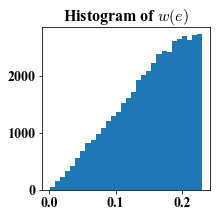

In [64]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

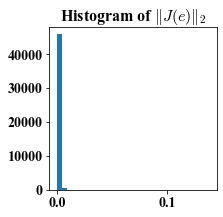

In [65]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

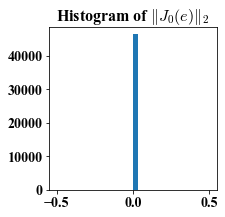

In [66]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt0_norm, bins=30)
plt.title('Histogram of $\\left\\|J_0(e)\\right\\|_2$')
plt.show()

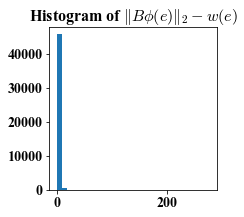

In [67]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

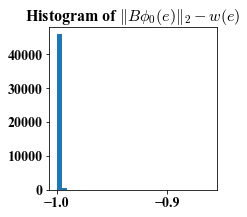

In [68]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score0, bins=30)
plt.title('Histogram of $\\left\\|B\\phi_0(e)\\right\\|_2-w(e)$')
plt.show()

In [69]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
#fit_obj = LocallyLinearEmbedding(n_components=d, n_neighbors=7, method='ltsa')
fit_obj = Isomap(n_components=d, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
embedding = fit_obj.fit_transform(X)

In [70]:
%matplotlib inline
def make_plots(phi, edge_score, J_opt):
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]

    node_size = np.ones(n)*2
    node_size[source] = 50
    node_size[dest1] = 50
    node_size[dest2] = 50
    node_color = ['g']*n
    node_color[source] = "y"
    node_color[dest1] = "r"
    node_color[dest2] = "g"

    Bphi = B.dot(phi).reshape((W.shape[0],-1))
    edge_color = np.linalg.norm(Bphi, axis=1)

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "edge_cmap": plt.cm.jet,
        "with_labels": False,
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|B\\phi(e)\\right\\|_2$')
    plt.show()
    
    ###########
    
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]

    edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "edge_cmap": plt.cm.binary,
        "with_labels": False,
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|J(e)\\right\\|_2> 0$')
    plt.show()
    
    ########
    
    
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]

    #edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')
    # edge_color = np.concatenate([J_opt[:,0:1]/np.max(J_opt[:,0:1]),
    #                              J_opt[:,1:2]/np.max(J_opt[:,1:2]),
    #                              J_opt[:,0:1]*0.1,  J_opt[:,0:1]*0+1], axis=1)
    edge_color = np.linalg.norm(J_opt, axis=1)
    edge_color = edge_color/np.max(edge_color)

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "with_labels": False,
        "edge_cmap": plt.cm.jet
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|J(e)\\right\\|_2$')
    plt.show()
    
    ##########
    
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]


    J = J_opt
    mask = (edge_score > 0)
    J_ = J[mask,:]

    edge_color = np.zeros((J.shape[0],4))
    edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
    edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
    edge_color[mask,-1] = edge_score[mask]/np.max(edge_score[mask])
    

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "with_labels": False,
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|(B\\phi)(e)\\right\\|_2- w(e)> 0$')
    plt.show()

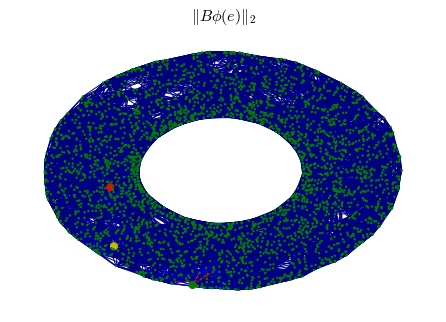

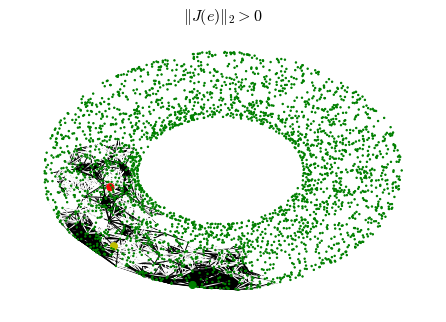

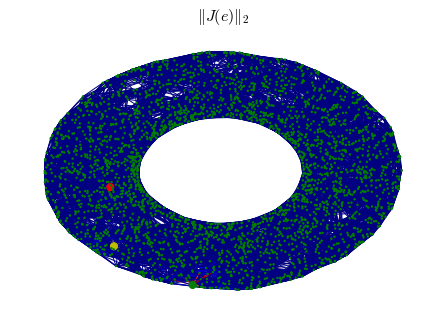

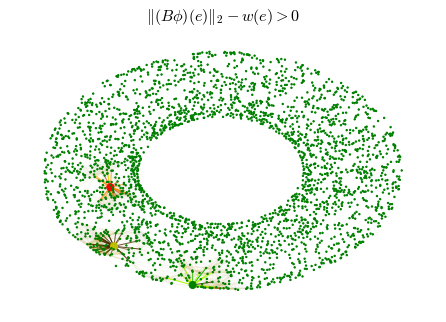

In [71]:
make_plots(phi, edge_score, J_opt)

# 3d network plot

In [82]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
#fit_obj = LocallyLinearEmbedding(n_components=d, n_neighbors=7, method='ltsa')
#fit_obj = Isomap(n_components=d+1, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
#embedding = fit_obj.fit_transform(X)

embedding = X

In [83]:
theta = nx.get_edge_attributes(CG, 'theta')
theta = np.array(list(theta.values()))
reflection = nx.get_edge_attributes(CG, 'reflection')
reflection = np.array(list(reflection.values()))

In [84]:
#J = B.dot(phi).reshape(CG.number_of_edges(), d)
#J = B.dot(phi0).reshape(CG.number_of_edges(), d)
#J = J_opt0
J = J_opt

/tmp/ipykernel_17240/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


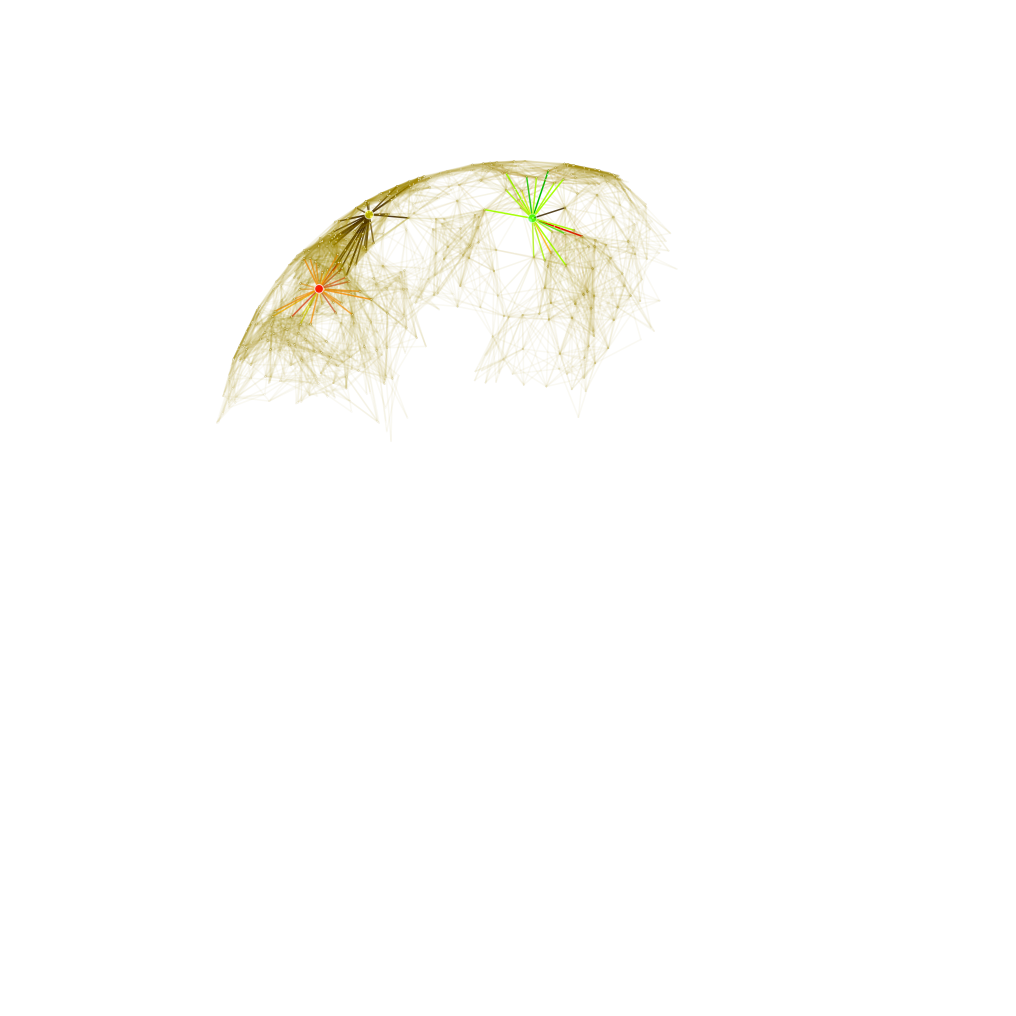

In [85]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]

#m_ = (np.max(J_[:,1]) - np.min(J_[:,1]))
#edge_color[mask,:] = cm.jet(J_[:,1] + m_*(J_[:,0] - np.min(J_[:,0]))/(np.max(J_[:,0]) - np.min(J_[:,0])))

#edge_color[:,-1] = (edge_score > 0).astype('float32')
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=57, azim=-79)
plt.show()

/tmp/ipykernel_17240/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


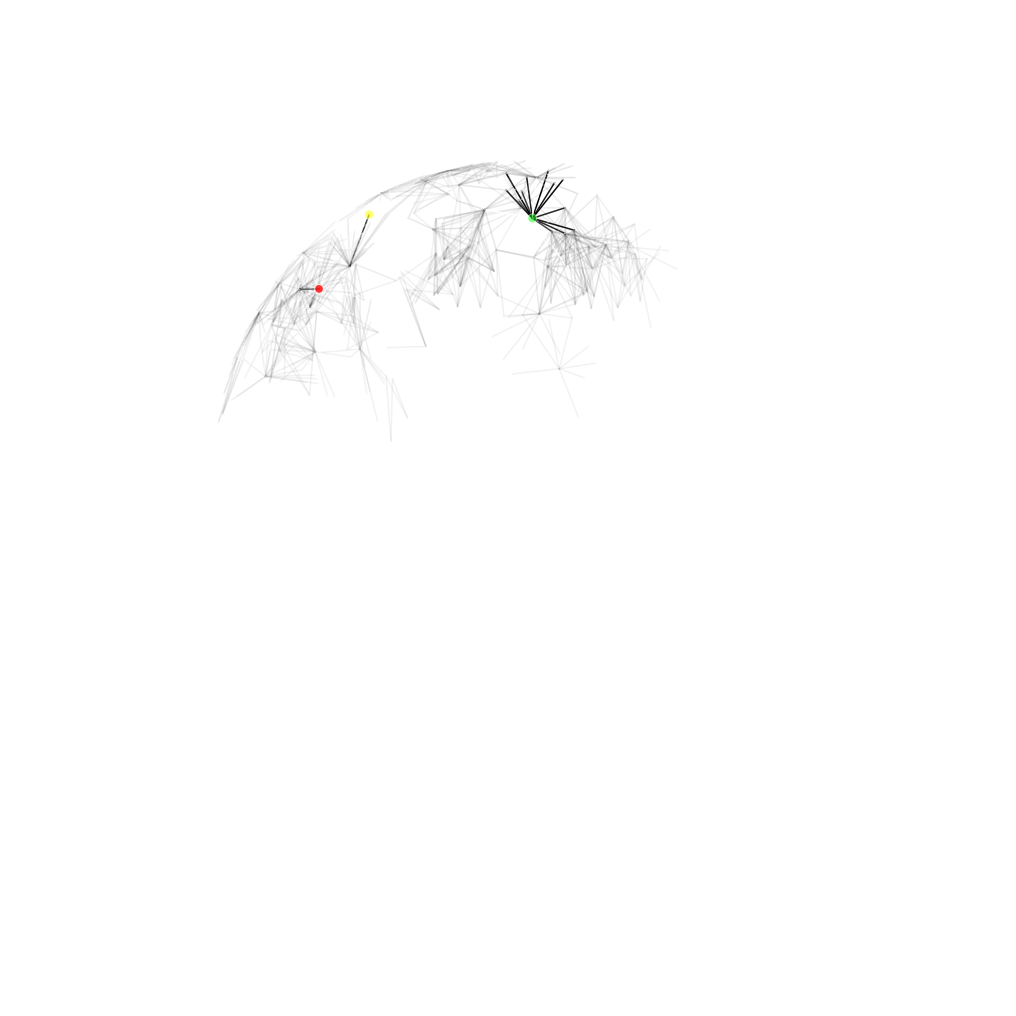

In [86]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = reflection[mask] > 0
edge_color[mask,1] = edge_color[mask,0]
edge_color[mask,2] = edge_color[mask,0]

#m_ = (np.max(J_[:,1]) - np.min(J_[:,1]))
#edge_color[mask,:] = cm.jet(J_[:,1] + m_*(J_[:,0] - np.min(J_[:,0]))/(np.max(J_[:,0]) - np.min(J_[:,0])))

#edge_color[:,-1] = (edge_score > 0).astype('float32')
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=57, azim=-79)
plt.show()

/tmp/ipykernel_17240/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


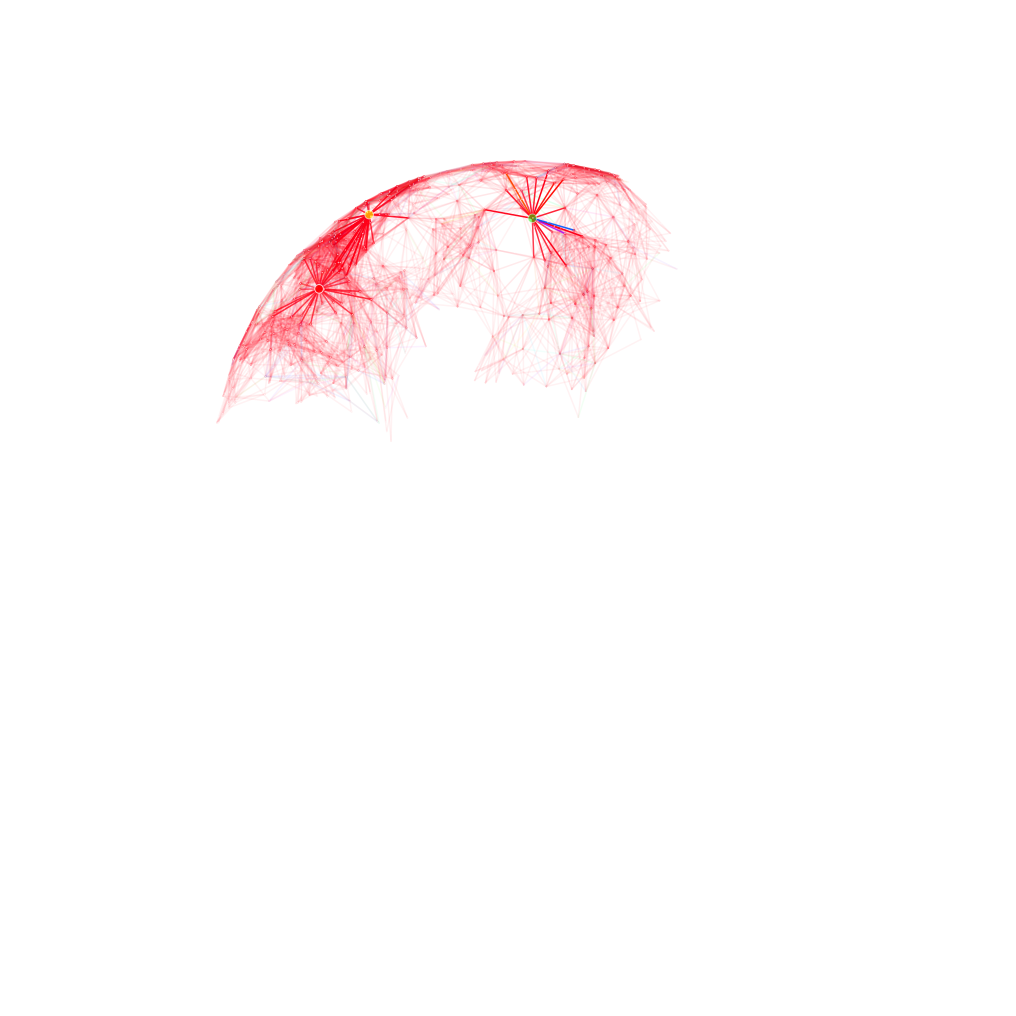

In [87]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,:] = cm.hsv(theta[mask])

#m_ = (np.max(J_[:,1]) - np.min(J_[:,1]))
#edge_color[mask,:] = cm.jet(J_[:,1] + m_*(J_[:,0] - np.min(J_[:,0]))/(np.max(J_[:,0]) - np.min(J_[:,0])))

#edge_color[:,-1] = (edge_score > 0).astype('float32')
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=57, azim=-79)
plt.show()

In [78]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

/tmp/ipykernel_17240/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


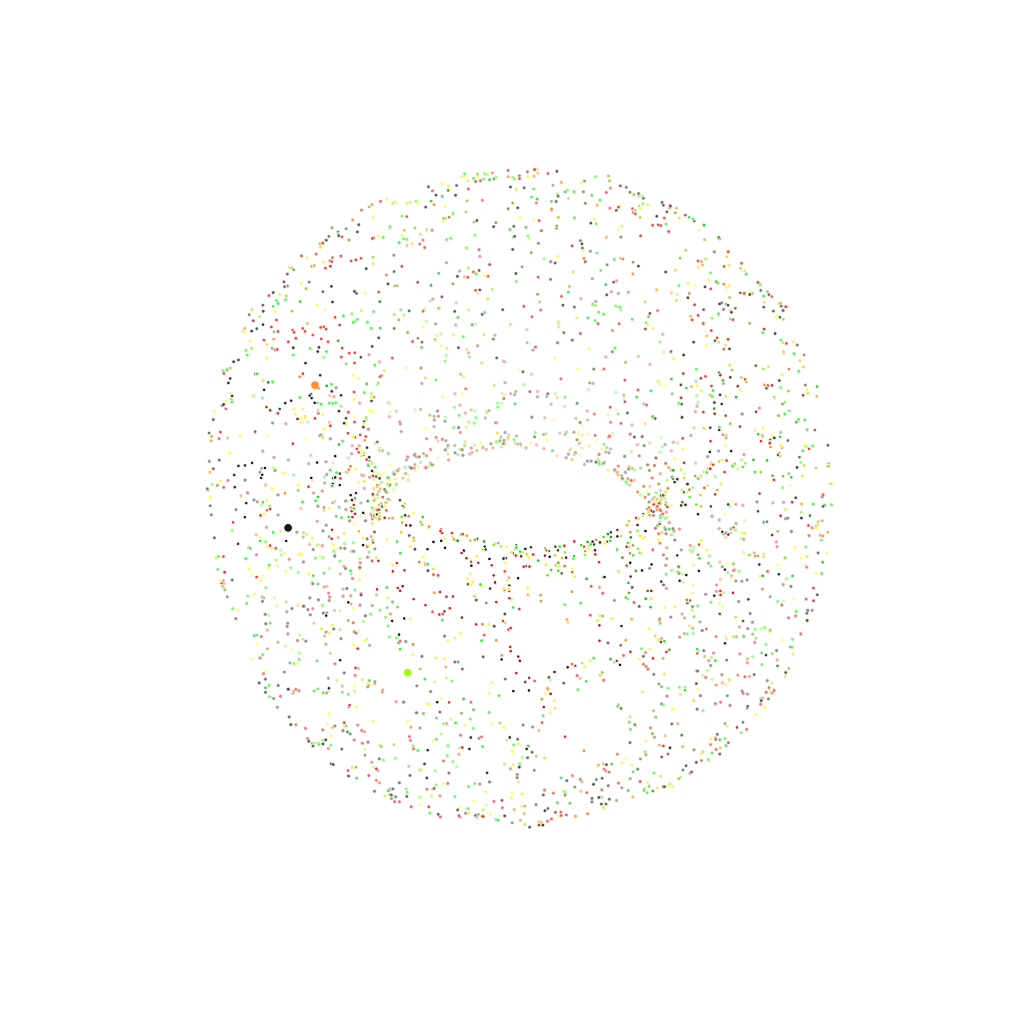

In [80]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*50
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = cm.Greys((node_color_[:,0] - np.min(node_color_[:,0])/np.ptp(node_color_[:,0])))[:,0]
node_color[:,1] = cm.Greys((node_color_[:,1] - np.min(node_color_[:,1])/np.ptp(node_color_[:,1])))[:,1]
edge_color = np.zeros((edge_score.shape[0], 4))
#edge_color = cm.Greys((edge_score > 0).astype('float32'))
#edge_color[:,-1] = (edge_score > 0).astype('float32')

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=57, azim=-79)
plt.show()